In [12]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [14]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [9]:
cursor.execute('Select * from "ahshouseholdclass"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [80]:
df = pd.read_csv('AHS Household Class.csv')

In [69]:
df.head()

,Unnamed: 0,CONTROL,YEAR,RATINGHS_BIN,RATINGHS,STORIES,UFINROOMS,BEDROOMS,HHOLDKIDS,KITCHENS,...,OWNLOT,WINBARS,KITCHSINK,GARAGE,HHSEE,HHERRND,FIRSTHOME,WASHER,DISHWASH,HHSEX
0,0,11000006,2017,extremely satisfied,10,1.0,0.0,3.0,0.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
1,3,11000023,2017,satisfied,8,3.0,0.0,3.0,0.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
2,4,11000046,2017,extremely satisfied,10,1.0,0.0,3.0,3.0,1.0,...,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
3,5,11000048,2017,very satisfied,9,3.0,0.0,4.0,2.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
4,6,11000052,2017,not satisfied,5,2.0,0.0,4.0,0.0,1.0,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


In [197]:
cursor.execute('Select * from "AHS_Household_Class"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df1 = pd.DataFrame(data=rows, columns=col_names )

In [198]:
df['RATINGHS'] = df1['RATINGHS']

In [73]:
df.head()

,Unnamed: 0,CONTROL,YEAR,STORIES,UFINROOMS,BEDROOMS,HHOLDKIDS,KITCHENS,ELECAMT,HHADLTKIDS,...,OWNLOT,WINBARS,KITCHSINK,GARAGE,HHSEE,HHERRND,FIRSTHOME,WASHER,DISHWASH,HHSEX
0,0,11000006,2017,1.0,0.0,3.0,0.0,1.0,120.0,0.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
1,3,11000023,2017,3.0,0.0,3.0,0.0,1.0,450.0,0.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
2,4,11000046,2017,1.0,0.0,3.0,3.0,1.0,130.0,0.0,...,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
3,5,11000048,2017,3.0,0.0,4.0,2.0,1.0,120.0,0.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
4,6,11000052,2017,2.0,0.0,4.0,0.0,1.0,140.0,0.0,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20108 entries, 0 to 20107
Data columns (total 82 columns):
Unnamed: 0      20108 non-null int64
CONTROL         20108 non-null int64
YEAR            20108 non-null int64
RATINGHS_BIN    20108 non-null object
RATINGHS        20108 non-null int64
STORIES         20108 non-null float64
UFINROOMS       20108 non-null float64
BEDROOMS        20108 non-null float64
HHOLDKIDS       20108 non-null float64
KITCHENS        20108 non-null float64
ELECAMT         20108 non-null float64
HHADLTKIDS      20108 non-null float64
FINROOMS        20108 non-null float64
NUMVETS         20108 non-null float64
HHMOVE          20108 non-null float64
NUMOLDKIDS      20108 non-null float64
TRASHAMT        20108 non-null float64
WATERAMT        20108 non-null float64
FINCP           20108 non-null float64
BATHROOMS       20108 non-null float64
NUMSUBFAM       20108 non-null float64
NUMSECFAM       20108 non-null float64
UNITSIZE        20108 non-null float64
NUM

In [132]:
df.describe()

,index,CONTROL,YEAR,BEDROOMS,STORIES,PERPOVLVL,HHADLTKIDS,HINCP,UNITSIZE,NUMVETS,...,KITCHSINK,HHERRND,WINBARS,HHWALK,HHHEAR,HHSEX,HHMEMRY,GARAGE,DISHWASH,RATINGHS
count,20108.000000,2.010800e+04,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,...,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000
mean,10053.500000,1.104341e+07,2015.945494,2.978267,1.796002,280.166849,0.250050,49811.449373,4.785011,0.140740,...,1.002934,1.953601,1.951611,1.905610,1.942411,1.493982,1.959767,1.295653,1.341755,8.455093
std,5804.823942,2.481080e+04,0.998538,0.801398,0.947553,145.777107,0.573392,27028.115068,1.283847,0.359851,...,0.054090,0.210354,0.214592,0.292378,0.232970,0.499976,0.196510,0.456347,0.474310,1.526876
min,0.000000,1.100001e+07,2015.000000,0.000000,1.000000,1.000000,0.000000,4.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5026.750000,1.102198e+07,2015.000000,3.000000,1.000000,162.000000,0.000000,27700.000000,4.000000,0.000000,...,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000
50%,10053.500000,1.104361e+07,2015.000000,3.000000,2.000000,272.000000,0.000000,49000.000000,5.000000,0.000000,...,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,9.000000
75%,15080.250000,1.106504e+07,2017.000000,3.000000,2.000000,403.000000,0.000000,72000.000000,5.000000,0.000000,...,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000
max,20107.000000,1.108700e+07,2017.000000,5.000000,7.000000,501.000000,6.000000,100000.000000,9.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000


In [67]:
df.columns

Index(['Unnamed: 0', 'CONTROL', 'YEAR', 'STORIES', 'UFINROOMS', 'BEDROOMS',
       'HHOLDKIDS', 'KITCHENS', 'ELECAMT', 'HHADLTKIDS', 'FINROOMS', 'NUMVETS',
       'HHMOVE', 'NUMOLDKIDS', 'TRASHAMT', 'WATERAMT', 'FINCP', 'BATHROOMS',
       'NUMSUBFAM', 'NUMSECFAM', 'UNITSIZE', 'NUMADULTS', 'HHYNGKIDS',
       'UTILAMT', 'NUMELDERS', 'NUMYNGKIDS', 'NUMPEOPLE', 'OTHERAMT', 'HINCP',
       'PARTNER', 'PERPOVLVL', 'LOTSIZE', 'TOTROOMS', 'HHAGE', 'LAUNDY',
       'NUMNONREL', 'MULTIGEN', 'OILAMT', 'GASAMT', 'DINING', 'NUMERRND',
       'OMB13CBSA', 'MVG1COST', 'HHRACE', 'NUMHEAR', 'NUMWALK', 'MVG2COST',
       'MVG3COST', 'HSHLDTYPE', 'FIREPLACE', 'NUMCARE', 'HHMAR', 'HHNATVTY',
       'BLD', 'NUMMEMRY', 'MILHH', 'COOKFUEL', 'DIVISION', 'NUMSEE', 'HHCARE',
       'CONDO', 'FRIDGE', 'HHMEMRY', 'HHWALK', 'HHHEAR', 'NOSTEP', 'OWNLOT',
       'WINBARS', 'KITCHSINK', 'GARAGE', 'HHSEE', 'HHERRND', 'FIRSTHOME',
       'WASHER', 'DISHWASH', 'HHSEX'],
      dtype='object')

In [71]:
target = df['RATINGHS_BIN']

In [81]:
df= df.drop(['RATINGHS_BIN','LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN'], axis=1)

In [18]:
#identify  any null values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [82]:
# Change the data type to int32
df.astype('int32').dtypes

Unnamed: 0    int32
CONTROL       int32
YEAR          int32
RATINGHS      int32
STORIES       int32
              ...  
HHERRND       int32
FIRSTHOME     int32
WASHER        int32
DISHWASH      int32
HHSEX         int32
Length: 77, dtype: object

In [85]:
df.columns

Index(['index', 'CONTROL', 'YEAR', 'BEDROOMS', 'STORIES', 'PERPOVLVL',
       'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE', 'UFINROOMS',
       'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM', 'OILAMT',
       'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT', 'TOTROOMS',
       'HHYNGKIDS', 'NUMSUBFAM', 'BATHROOMS', 'NUMYNGKIDS', 'TRASHAMT',
       'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT', 'ELECAMT',
       'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS', 'NUMCARE',
       'NUMWALK', 'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST',
       'MILHH', 'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMERRND',
       'NUMSEE', 'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'FIREPLACE',
       'CONDO', 'OWNLOT', 'FRIDGE', 'FIRSTHOME', 'HHCARE', 'NOSTEP', 'WASHER',
       'HHSEE', 'KITCHSINK', 'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GARAGE', 'DISHWASH', 'RATINGHS'],
      dtype='object')

In [88]:
#df['HINCP'].hist()

## Distribution 

In [20]:
matplotlib.style.use('ggplot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c182c8c18>,
      dtype=object)

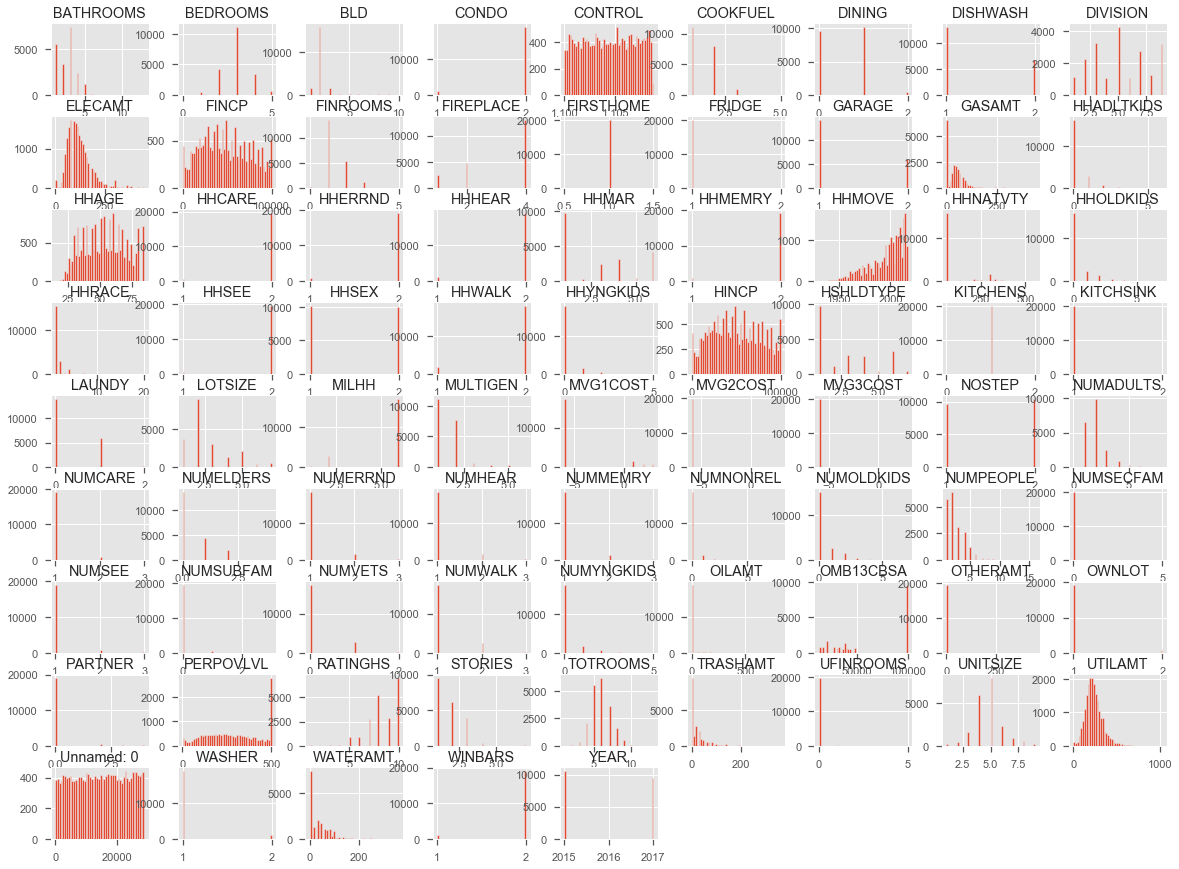

In [21]:
df.hist(bins=50, figsize=(20,15))

##### Fridge and Kitchsink have only Yes values - do we need this feature for our model

In [ ]:
df_move.hist(bins=50, figsize=(20,15))

#### alot of -6 values for move relative features 

In [ ]:
df_rooms.hist(bins=50, figsize=(20,15))

#### Seem like every unit has one kitchen - should we drop this feature?



In [ ]:
df_search.hist(bins=50, figsize=(20,15))

####  should we drop few features?


In [ ]:
#Household Income (past 12 months)
df_sub['HINCP'].hist(bins=100)

In [ ]:
#Monthly total mortgage amount (all mortgages)
#df_sub['MORTAMT'].value_counts()

In [ ]:
#df_sub['MORTAMT'].value_counts()

In [ ]:
df_sub['HINCP'].value_counts()

In [ ]:
#Transform the income from year to monthly
df_sub['HINCP']= df_sub['HINCP'].divide(12)
df_sub['HINCP']

In [ ]:
#Correlation with target to other features
corr_matrix = df_sub.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

In [ ]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
#attributes = ['RATINGHS', 'HINCP', 'UNITSIZE', 'BEDROOMS', 'BLD' ]
attributes = ['HINCP','RATINGHS', 'TOTROOMS','DINING', 'LAUNDY', 'STORIES', 'FRIDGE','KITCHSINK', 'COOKFUEL', 'FIREPLACE']
scatter_matrix(df_sub[attributes], alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

In [33]:
df_1 = df[['RATINGHS','LOTSIZE', 'UFINROOMS','HINCP','HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GARAGE', 'DISHWASH', 'TOTROOMS','DINING', 'LAUNDY', 'STORIES', 'FRIDGE', 'KITCHSINK', 'COOKFUEL', 'FIREPLACE']]

In [35]:
df_cof = df[['RATINGHS','PERPOVLVL', 'NUMELDERS','TOTROOMS','BEDROOMS','OMB13CBSA','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]

In [87]:
df_f = df[['PERPOVLVL', 'NUMELDERS','BEDROOMS','UNITSIZE','OMB13CBSA','BATHROOMS', 'HHMOVE', 
           'UTILAMT','HHNATVTY','HINCP','FINCP', 'RATINGHS','TRASHAMT', 'WATERAMT', 'LOTSIZE', 'UFINROOMS',
           'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
           'HHMEMRY', 'GARAGE', 'DISHWASH', 'TOTROOMS','DIVISION','DINING', 'LAUNDY', 
           'STORIES', 'FRIDGE', 'KITCHSINK', 'COOKFUEL', 'FIREPLACE']]

### Run the correlation again

In [36]:
corr_matrix = df.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

RATINGHS     1.000000
BATHROOMS    0.122283
UNITSIZE     0.122050
NUMELDERS    0.120224
TOTROOMS     0.117428
               ...   
FIREPLACE   -0.084583
HHMOVE      -0.092285
GARAGE      -0.092718
DISHWASH    -0.102172
FIRSTHOME         NaN
Name: RATINGHS, Length: 77, dtype: float64

In [37]:
df_cof = df[['RATINGHS','PERPOVLVL', 'NUMELDERS','BEDROOMS','OMB13CBSA','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]

In [38]:
corr_matrix = df_1.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

RATINGHS     1.000000
TOTROOMS     0.117428
LOTSIZE      0.063994
DINING       0.048323
HHMEMRY      0.039707
LAUNDY       0.034716
HHWALK       0.028703
HHERRND      0.028554
HINCP        0.026388
HHSEX        0.023194
WINBARS      0.020766
STORIES      0.017886
UFINROOMS    0.002422
HHHEAR      -0.005263
FRIDGE      -0.012919
COOKFUEL    -0.023987
KITCHSINK   -0.027475
FIREPLACE   -0.084583
GARAGE      -0.092718
DISHWASH    -0.102172
Name: RATINGHS, dtype: float64

 ### Rank-by-feature

To visualize the correlation matrix for your features

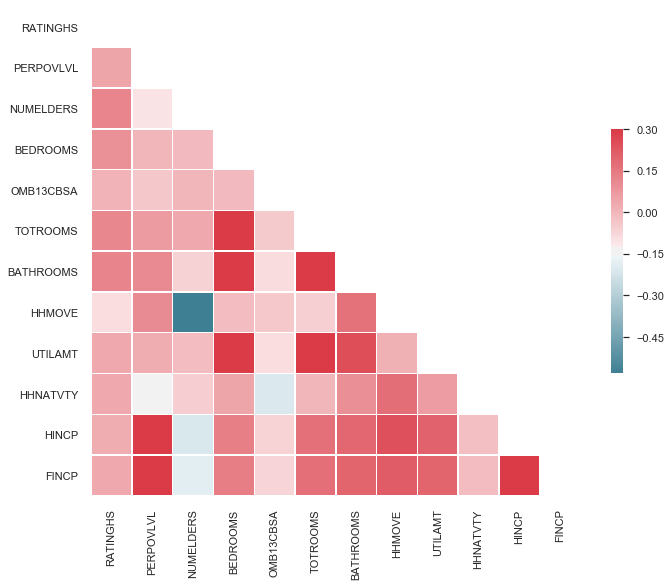

In [39]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_cof.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [40]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_exp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

NameError: name 'df_exp' is not defined

In [ ]:
# Will drop features ELECAMT', 'GASAMT', 'OILAMT', 'OTHERAMT','TRASHAMT', 'WATERAMT' and Keep only utilamount 
df = df.drop(columns=['ELECAMT', 'GASAMT', 'OILAMT', 'OTHERAMT','TRASHAMT', 'WATERAMT'])


In [ ]:
df.columns

In [191]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_search.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

NameError: name 'df_search' is not defined

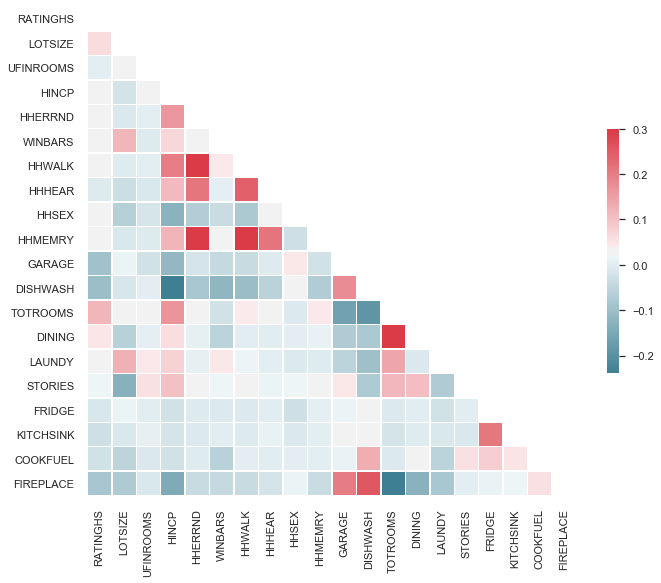

In [41]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Balanced Binning

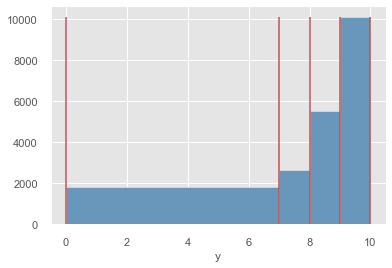

In [137]:
from yellowbrick.datasets import load_concrete
from yellowbrick.target import BalancedBinningReference


# Instantiate the visualizer
visualizer = BalancedBinningReference(bins=[0,7,8,9,10])

y = df_sub['RATINGHS']
visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [138]:
df = df[[c for c in df if c not in ['RATINGHS']] + ['RATINGHS']]


In [139]:
labels = df['RATINGHS']

## Feature Analysis


In [140]:


LABEL_MAP = {
    1: "Un-Satisfied",
    2: "Un-Satisfied",
    3: "Un-Satisfied",
    4: "Un-Satisfied",
    5: "Un-Satisfied",
    6: "Un-Satisfied",
    7: "Satisfied",
    8: "Satisfied",
    9: "Highly Satisfied",
    10: "Extreme Satisfied"
}

# Convert class labels into text
df['RATINGHS'] = df['RATINGHS'].map(LABEL_MAP)


In [141]:
#df_sub['RATINGHS'] = df_sub['RATINGHS'].astype(str)
df['RATINGHS']

0        Extreme Satisfied
1                Satisfied
2         Highly Satisfied
3                Satisfied
4        Extreme Satisfied
               ...        
20103    Extreme Satisfied
20104            Satisfied
20105    Extreme Satisfied
20106    Extreme Satisfied
20107         Un-Satisfied
Name: RATINGHS, Length: 20108, dtype: object

In [142]:
# Extract our X and y data
X = df[['TOTROOMS','DINING', 'LAUNDY', 'STORIES', 'FRIDGE', 'KITCHSINK', 'COOKFUEL', 'FIREPLACE']].values
#y = df['RATINGHS'].values

### Encode our target variable

In [143]:
from sklearn.preprocessing import LabelEncoder
# Encode our target variable

encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

y

array([9, 7, 8, ..., 9, 9, 0])

In [144]:
y = df['RATINGHS']

In [145]:
print(X.shape, y.shape)

(20108, 8) (20108,)


In [48]:
#from yellowbrick.features import RadViz
#classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]
#
#_ = RadViz(size=(1080, 720),classes=classes, alpha=0.35).fit_transform_show(X, y)

## Parallel Coordinates


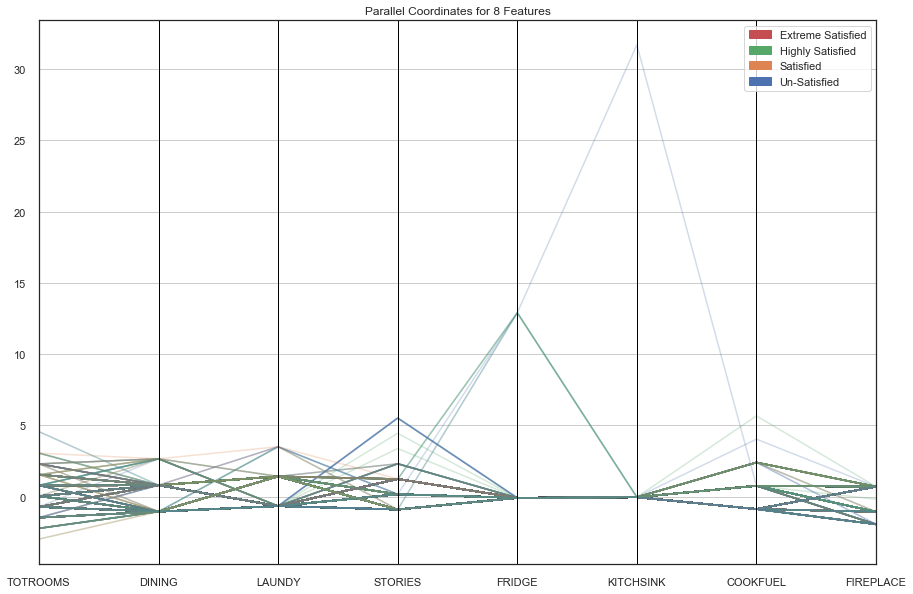

In [101]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    'TOTROOMS','DINING', 'LAUNDY', 'STORIES', 'FRIDGE', 'KITCHSINK', 'COOKFUEL', 'FIREPLACE'
]
classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', 
    sample=0.05, shuffle=True, size=(1080, 720)
)

# Fit the visualizer and display it
visualizer.fit(X, y)
visualizer.transform(X)

visualizer.show()

In [ ]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    'TOTROOMS','DINING', 'LAUNDY', 'STORIES', 'FRIDGE', 'KITCHSINK', 'COOKFUEL', 'FIREPLACE'
]
classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='minmax', 
    sample=0.05, shuffle=True, size=(1080, 720)
)

# Fit the visualizer and display it
visualizer.fit(X, y)
visualizer.transform(X)

visualizer.show()

## Feature Importance

In [147]:
df = df[[c for c in df if c not in ['RATINGHS']] + ['RATINGHS']]
y

0        Extreme Satisfied
1                Satisfied
2         Highly Satisfied
3                Satisfied
4        Extreme Satisfied
               ...        
20103    Extreme Satisfied
20104            Satisfied
20105    Extreme Satisfied
20106    Extreme Satisfied
20107         Un-Satisfied
Name: RATINGHS, Length: 20108, dtype: object

In [148]:

y = df['RATINGHS']
X = df.drop(['RATINGHS'], axis=1)



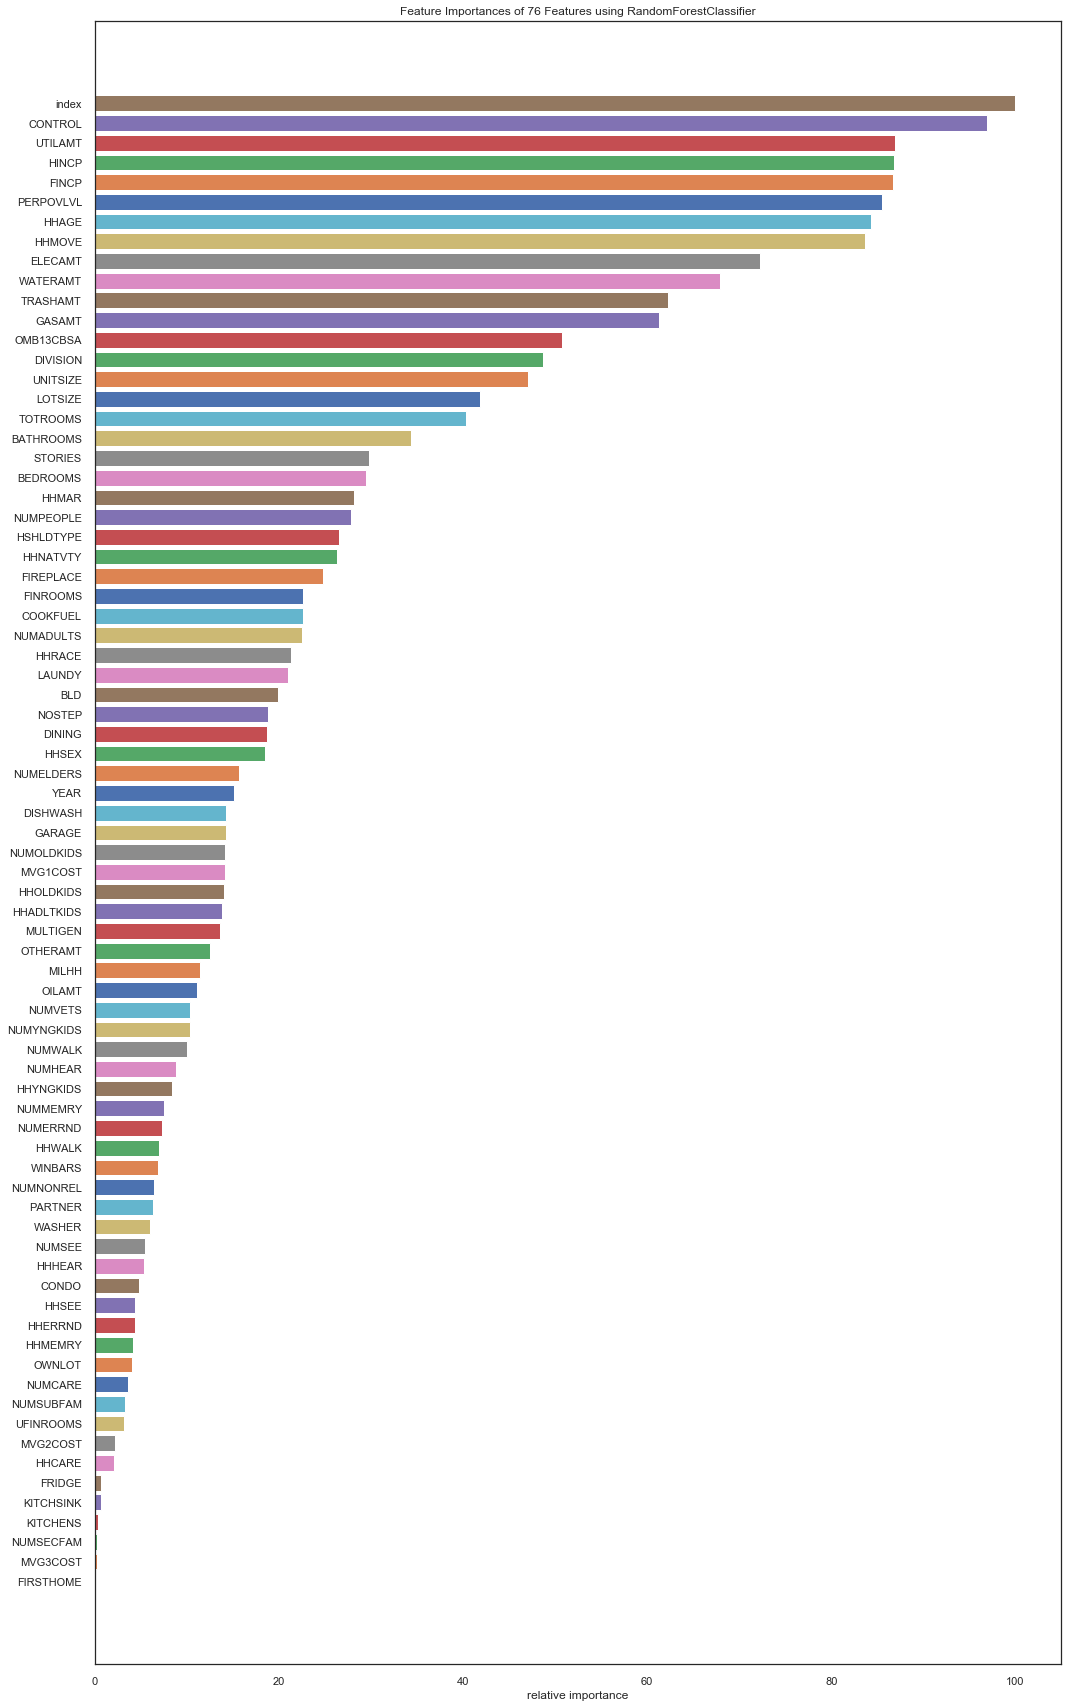

In [104]:
#Using Randomforest classifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

In [105]:
# Create a dictionary that will map the feature name with its feature importance
feats = {}

# Loop through Feature
for feature, importance in zip(X.columns, model.feature_importances_):
    feats[feature] = importance # Add the name/value pair

# View our dictionary, but sorted in order of importance
sorted(feats.items(), key=lambda x: x[1], reverse=True)

[('index', 0.051981382784914695),
 ('CONTROL', 0.05038788820049692),
 ('UTILAMT', 0.04520291442264194),
 ('HINCP', 0.04514025561330624),
 ('FINCP', 0.04505803386767727),
 ('PERPOVLVL', 0.04445595822679968),
 ('HHAGE', 0.04385561255411714),
 ('HHMOVE', 0.043466275158175714),
 ('ELECAMT', 0.037545382759935866),
 ('WATERAMT', 0.03528942534401772),
 ('TRASHAMT', 0.032355181788371934),
 ('GASAMT', 0.031866656819776455),
 ('OMB13CBSA', 0.026360793017783574),
 ('DIVISION', 0.02528388384810116),
 ('UNITSIZE', 0.02445582923171753),
 ('LOTSIZE', 0.021724993017254494),
 ('TOTROOMS', 0.020930764117411245),
 ('BATHROOMS', 0.017877455415823966),
 ('STORIES', 0.015486703330489137),
 ('BEDROOMS', 0.015302058544365588),
 ('HHMAR', 0.014628641618250438),
 ('NUMPEOPLE', 0.014446024401734259),
 ('HSHLDTYPE', 0.01378241869508818),
 ('HHNATVTY', 0.013688417092235177),
 ('FIREPLACE', 0.012895156697562794),
 ('FINROOMS', 0.01174805523171207),
 ('COOKFUEL', 0.011739480266000272),
 ('NUMADULTS', 0.0117197980562

In [ ]:
# Drop Neightborhood rating since it's highly corelative

#X = X.drop(['RATINGNH'], axis=1)
#X

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


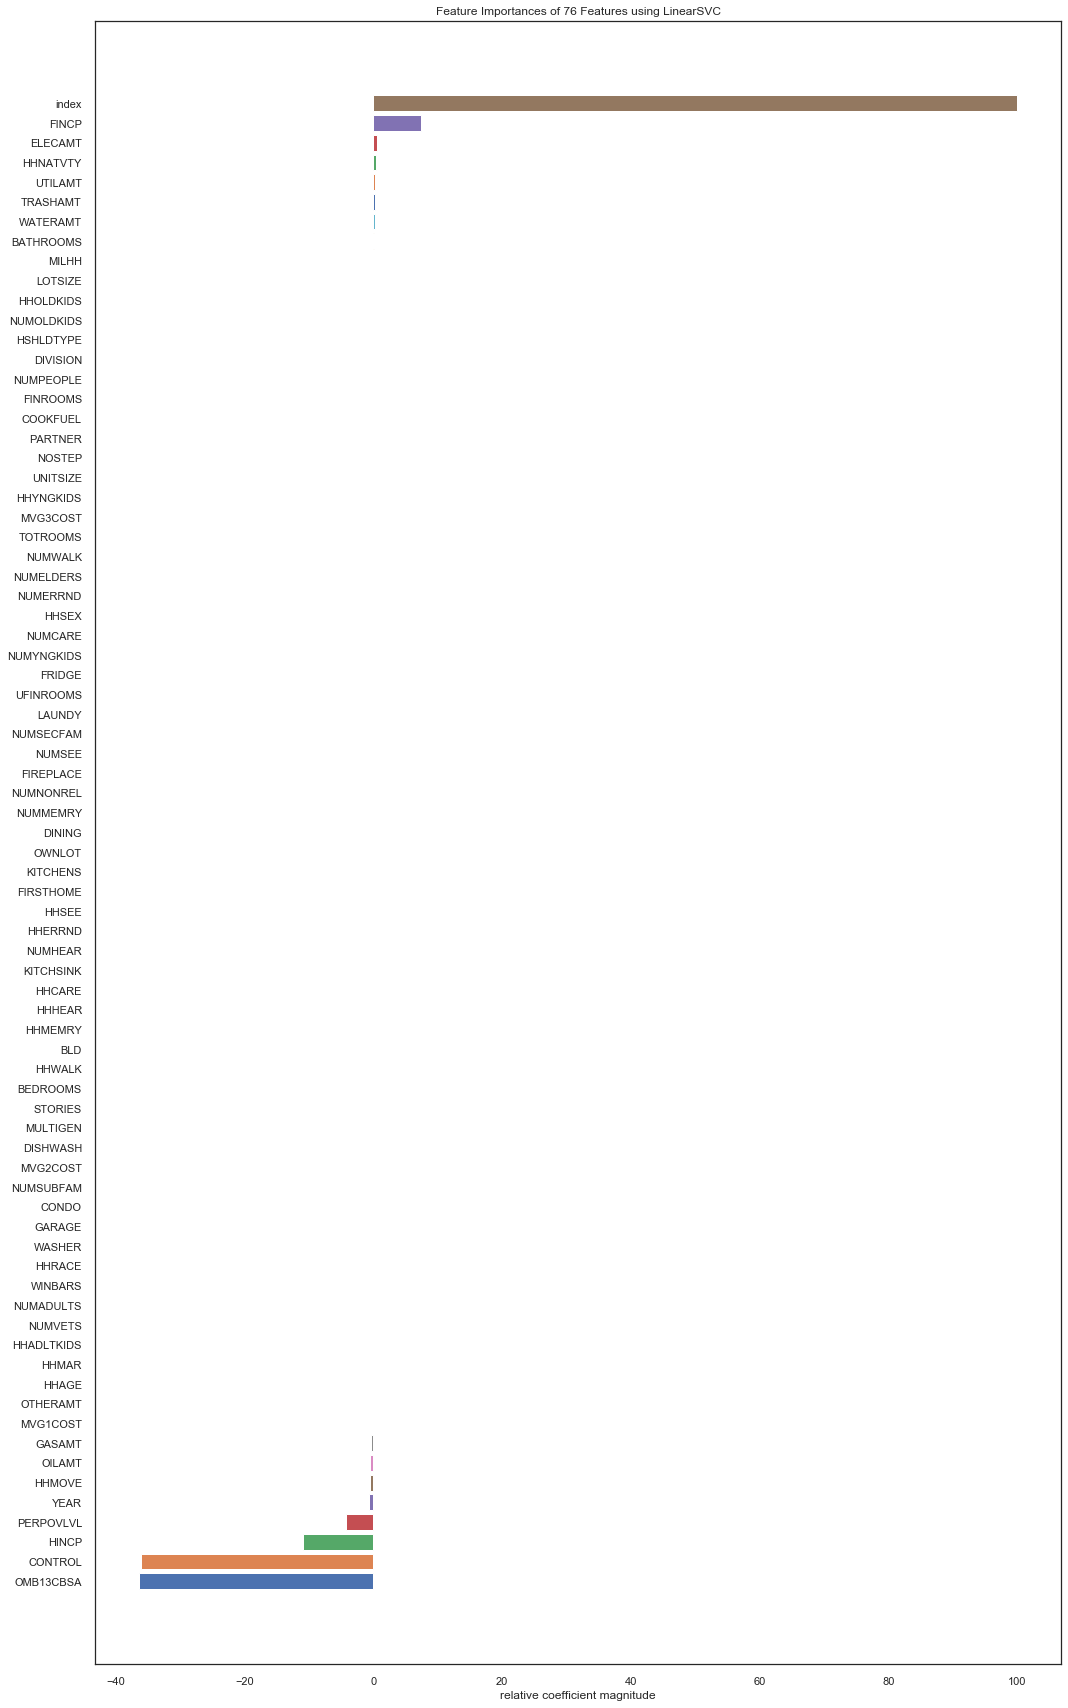

In [106]:
# Using LinearSVC model
from sklearn import svm
from yellowbrick.features import FeatureImportances

model = svm.LinearSVC()
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

In [ ]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(3000, 2000))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

### Correlation Matrix with Heatmap

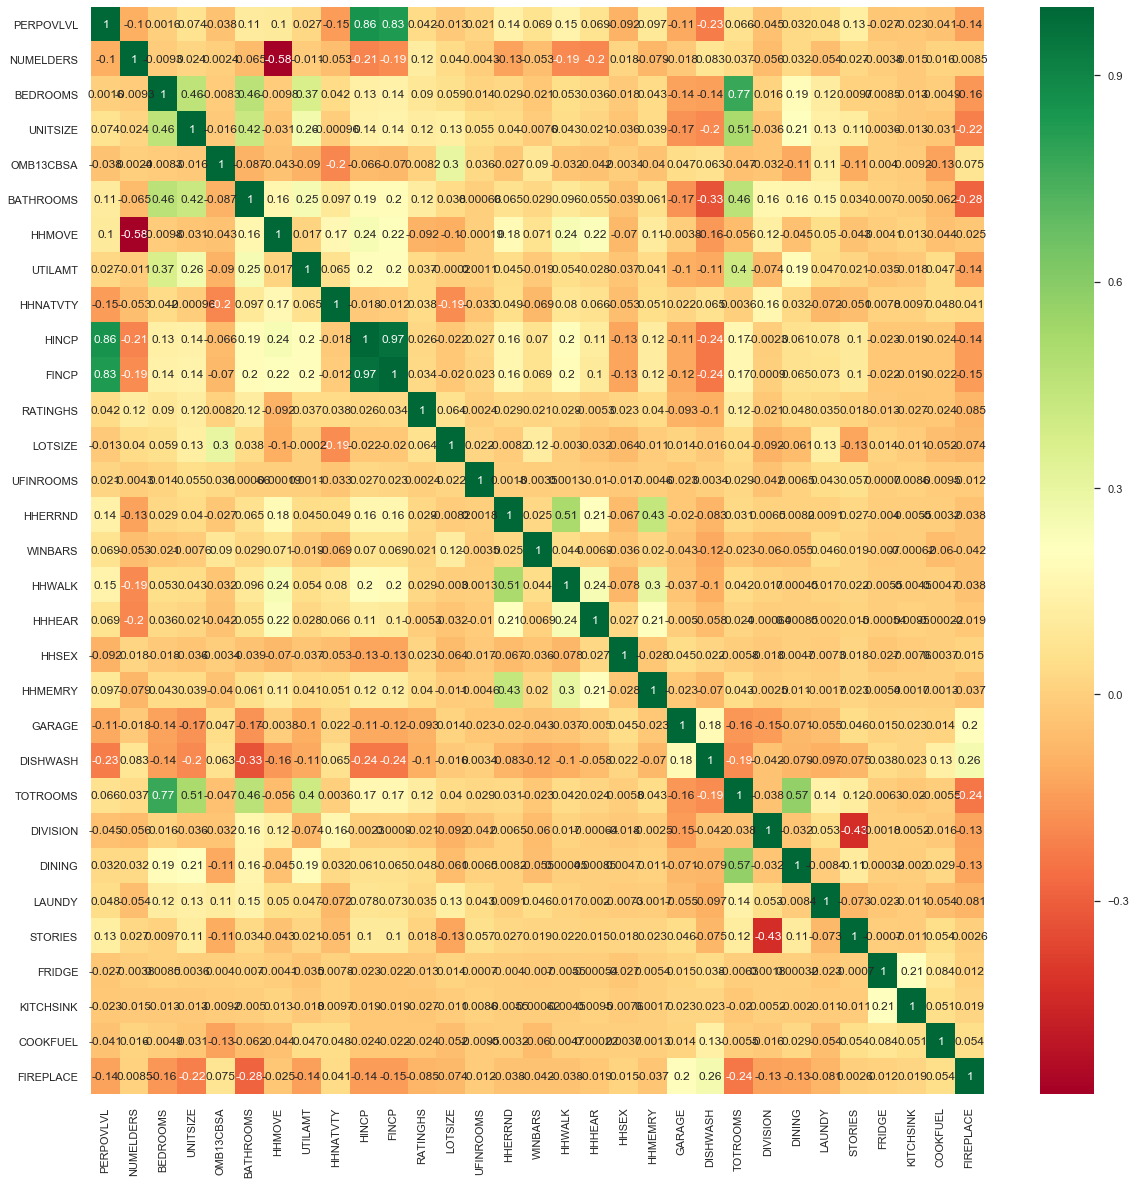

In [86]:
corrmat = df_f.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_f[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Feature Selection

In [55]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import ExtraTreesClassifier


In [74]:
features = df
labels = target

In [75]:
model = LogisticRegression()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['Unnamed: 0', 'FINCP', 'HINCP', 'OMB13CBSA']


In [76]:
model = RandomForestClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['Unnamed: 0', 'CONTROL', 'STORIES', 'BEDROOMS', 'ELECAMT', 'HHMOVE', 'TRASHAMT', 'WATERAMT', 'FINCP', 'BATHROOMS', 'UNITSIZE', 'UTILAMT', 'NUMPEOPLE', 'HINCP', 'PERPOVLVL', 'LOTSIZE', 'TOTROOMS', 'HHAGE', 'GASAMT', 'OMB13CBSA', 'HSHLDTYPE', 'HHMAR', 'HHNATVTY', 'DIVISION']


In [77]:
model = SGDClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['Unnamed: 0', 'FINCP', 'HINCP', 'OMB13CBSA']


#### Based on the feature importance and SelectfromModel - top features are:
PERPOVLVL', 'NUMELDERS','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS', 'HHMOVE',
        'UTILAMT', 'DIVISION','UNITSIZE', 'HHNATVTY', 'HINCP_BIN','HHWALK', 'HHHEAR', 'HHSEX',
        'GARAGE', 'DISHWASH','DINING', 'LAUNDY'
        